##### 영화 리뷰 분류: 이진 분류 예제
텍스트를 기반으로 영화 리뷰를 긍정(Positive)과 부정(Negative)으로 분류하는 법을 배움

이는 텍스트 데이터셋에 기본 신경망을 적용하여 분류함<br>
텍스트 데이터에 순환 신경망을 적용하는 방법은 다른 장에서 소개됨

##### IMDB 데이터셋
인터넷 영화 데이터베이스로부터 가져온 양극단의 리뷰 5만 개로 이루어진 IMDB 데이터셋을 사용<br>
이 데이터셋은 훈련 데이터 25,000개 테스트 데이터 25,000개로 나뉘어 있고 각각 긍정 부정 50%씩 구성되어있다.
<br>
MNIST 데이터셋처럼 IMDB 데이터셋도 케라스에 포함되어 있다. 이 데이터는 전처리되어 있어 각 리뷰(단어 시퀀스)가 숫자 시퀀스로 변환되어있다. 여기서 각 숫자는 사전에 있는 고유한 단어를 나타낸다.

##### 데이터셋 로드

In [1]:
from keras.datasets import imdb

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)
# num_words = 10000 매개변수는 훈련 데이터에서 가장 자주 나타나는 단어 1만 개만 사용하겠다는 의미
# 드물게 나타나는 단어는 무시함

변수 train_data와 test_data는 리뷰의 목록이다. 각 리뷰는 단어 인덱스의 리스트이다.(단어 시퀀스가 인코딩 된 것)<br>train_labels 와 test_labels는 부정을 나타내는 0과 긍정을 나타내는 1의 리스트이다.

In [2]:
train_data[0]
train_labels[0]

1

가장 자주 등장하는 단어 1만 개로 제한했기 때문에 단어 인덱스는 9,999를 넘지 않는다.

In [3]:
max([max(sequence) for sequence in train_data])

9999

재미 삼아 이 리뷰 데이터 하나를 원래 영단어로 어떻게 바꾸는지 본다.

In [4]:
word_index = imdb.get_word_index() # word_index는 단어와 정수 인덱스를 매핑한 딕셔너리이다.
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()]) # 정수 인덱스와 단어를 매핑하도록 뒤집는다.
decoded_review = ' '.join([reverse_word_index.get(i-3, '?') for i in train_data[0]]) # 리뷰를 디코딩한다. 0, 1, 2는 '패딩', '문서 시작', '사전에 없음'을 위한 인덱스 이므로 3을 뺀다.

decoded_review

"? this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert ? is an amazing actor and now the same being director ? father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for ? and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also ? to the two little boy's that played the ? of norman and paul they were just brilliant children are often left out of the ? list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have done don't you th

##### 데이터 준비
신경망에 숫자 리스트를 주입할 수는 없다. 리스트를 텐서로 바꾸는 두 가지 방법이 있다.
- 같은 길이가 되도록 리스트에 패딩(padding)을 추가하고, (samples, sequence_length) 크기의 정수 텐서로 변환한다. 그다음 이 정수 텐서를 다룰 수 있는 층을 신경망의 첫 번 째 층으로 사용한다.(Embedding 층을 말하며, 나중에 자세히 다룬다.)
- 리스트를 원-핫 인코딩(one-hot encoding)하여 0과 1의 벡터로 변환한다. 예를 들어 시퀀스 [3, 5]를 인덱스 3과 5의 위치는 1이고 그 외는 모두 0인 10,000차원의 벡터로 각각 변환한다.<span style="color: gray">(CountVectorizer 같은건가?)</span>그 다음 부동 소수 벡터 데이터를 다룰 수 있는 Dense 층을 신경망의 첫 번째 층으로 사용한다. <span style="color: gray">Dense층 들어본거 나왔다. 부동 소수 벡터를 다룰 수 있는 층인가보다.</span>

여기서는 두 번째 방식을 사용하고 이해를 돕기 위해 직접 데이터를 원-핫 벡터로 만든다.

In [5]:
import numpy as np

def vectorize_sequence(sequence, dimension=10000):
    results = np.zeros((len(sequence), dimension)) # 크기가 (len(sequence), dimension)이고 모든 원소가 0인 행렬을 만든다.
    for i, sequence in enumerate(sequence):
        results[i, sequence] = 1. # results[i]에서 특정 인덱스의 위치를 1로 만든다.
    return results

# 아 6행에서 왜 1로 만든다는데 1.으로 하는가 했더니 Dense층이 부동 소수 벡터를 다뤄서 그런가보다

x_train = vectorize_sequence(train_data)
x_test = vectorize_sequence(test_data)

샘플은 다음과 같이 나타난다.

In [6]:
x_train[0]

array([0., 1., 1., ..., 0., 0., 0.])

<span style="color: gray">시발 졸라 어렵네?</span>
<br> 레이블은 쉽게 벡터로 바꿀 수 있다.

In [7]:
y_train = np.asarray(train_labels).astype('float32') # 이놈도 float으로 바꾸는게 Dense층에서 부동 소수 벡터를 다뤄서 그런듯
y_test = np.asarray(test_labels).astype('float32')

y_train

array([1., 0., 0., ..., 0., 1., 0.], dtype=float32)

이제 신경망에 때려 넣을 데이터가 준비되었다.

##### 신경망 모델 만들기
입력 데이터가 벡터고 레이블은 스칼라(1 또는 0)이다. 아마 앞으로 볼 수 있는 문제 중에서 가장 간단할 것이다.<br>
이런 문제에 잘 작동하는 네트워크 종류는 relu 활성화 함수를 사용한 완전 연결 층(즉 Dense(16, activation='relu'))을 그냥 쌓은 것이다.<br><span style="color: gray">활성함수가 뭐에 쓰는건지 알아봐야겠다.</span><br>
Dense 층에 전달한 매개변수(16)는 은닉 유닛(hidden unit)의 개수이다. 하나의 은닉 유닛은 층이 나타내는 표현 공간에서 하나의 차원이 된다. 2장에서 relu 활성화 함수를 사용한 Dense 층을 다음 텐서 연산을 연결하여 구현했다.<br>
output = relu(dot(W, input) + b)<br>
<br>
16개의 은닉 유닛이 있다는 것은 가중치 행렬 W의 크기가 (input_dimension, 16)이라는 뜻이다. 입력 데이터와 W를 점곱하면 입력 데이터가 16차원으로 표현된 공간으로 투영된다.(그리고 편향 벡터 b를 더하고 relu 연산을 적용한다.) 표현 공간의 차원을 '신경망이 내재된 표현을 학습할 때 가질 수 있는 자유도'로 이해할 수 있다. 은닉 유닛을 늘리면(표현 공간을 더 고차원으로 만들면) 신경망이 더욱 복잡한 표현을 학습할 수 있지만 계산 비용이 커지고 원하지 않는 패턴을 학습할 수도 있다.(훈련 데이터에서는 성능이 향상되지만 테스트 데이터에서는 그렇지 않은 패턴이다.)<br>
Dense 층을 쌓을 때 두 가지 중요한 구조상의 결정이 필요하다.
- 얼마나 많은 층을 사용할 것인가?
- 각 층에 얼마나 많은 은닉 유닛을 둘 것인가?
<br>
<div>
4장에서 이런 결정을 하는 데 도움이 되는 일반적인 원리를 배운다. 당분간은 다음 구조를 따른다.
</div>

- 16개의 은닉 유닛을 가진 2개의 은닉 층
- 현재 리뷰의 감정을 스칼라 값의 예측으로 출력하는 세 번째 층


<span style="color: gray">아 ㅅㅂ 기억났다. 활성함수(activation function) 그 뭐야 가중치 받고서 들어온? 값을 내보낼지 안내보낼지 결정하는 함수<br>뭐 예를 들어 1보다 크면 내보내고 1보다 작으면 내보내지 않고 그거</span>

중간에 있는 은닉 층은 활성화 함수로 relu를 사용하고 마지막 층은 확률(0과 1사이의 점수로, 어떤 샘플이 타깃 '1'일 가능성이 높다는 것은 그 리뷰가 긍정일 가능성이 높다는 것을 의미한다.)을 출력하기 위해 시그모이드 활성화 함수를 사용한다. relu는 음수를 0으로 만드는 함수이다. (아래 그림 참조) 시그모이드는 임의의 값을 [0, 1] 사이로 압축하므로 출력 값을 확률처럼 해석할 수 있다.<br>
<span style="color: gray">이진 분류 즉, 0 아니면 1 이라서 relu 활성화 함수를 사용하는 건가?</span>

relu 함수<br>
<image src="./images/relu_function.jpg" style="width: 20%; height: 20%"></image>
<br>
시그모이드 함수<br>
<image src="./images/sigmoid_function.jpg" style="width: 20%; height: 20%"></image>

다음 그림에서 이 신경망을 보여준다.<br>
<image src="./images/network.jpg" style="width: 20%; height:20%">

##### 모델 정의하기

In [9]:
# 모델 생성
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

마지막으로 손실 함수와 옵티마이저를 선택해야 한다. 이진 분류 문제고 신경망의 출력이 확률이기 때문에<br>
(네트워크의 끝에 시그모이드 활성화 함수를 사용한 하나의 유닛으로 된 층을 놓았다.), binary_crossentropy 손실이 적합하다.
<br>이 함수가 유일한 선택은 아니고 mean_squared_error도 사용할 수 있다. 확률을 출력하는 모델을 사용할 때는 크로스 엔트로피가 최선의 선택이다. 크로스엔트로피(Crossentropy)는 정보 이론(Information Theory)분야에서 온 개념으로 확률 분포 간의 차이를 측정한다. 여기에서는 원본 분포와 예측 분포 사이를 측정한다.<br>
mean_squared_error 와 mean_absolute_error는 회귀 문제에 사용되는 대표적인 손실 함수이다.

다음은 rmsprop 옵티마이저와 binary_crossentropy 손실 함수로 모델을 설정하는 단계이다. 훈련하는 동안 정확도를 사용하여 모니터링 한다.

In [10]:
# 모델 컴파일 하기
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

##### 훈련 검증
훈련하는 동안 처음 본 데이터에 대한 모델의 정확도를 측정하기 위해서는 원본 훈련 데이터에서 10,000의 샘플을 떼어 검증 세트를 만들어야 한다.

In [11]:
# 검증 세트 준비
x_val = x_train[:10000]
partial_x_train = x_train[10000:]
y_val = y_train[:10000]
partial_y_train = y_train[10000:]

이제 모델을 512개의 샘플씩 미니 배치를 만들어 0번의 에포크 동안 훈련시킨다.(x_train과 y_train 텐서에 있는 모든 샘플에 대해 20번 반복한다.)<br>
동시에 따로 떼어 놓은 1만 개의 샘플에서 손실과 정확도를 측정할 것이다. 이렇게 하려면 validation_data 매개변수에 검증 데이터를 전달해야 한다.

In [13]:
# 모델 훈련하기
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

history = model.fit(partial_x_train, partial_y_train, epochs=20, batch_size=512, validation_data=(x_val, y_val))

Epoch 1/20
30/30 [==============================] - 2s 43ms/step - loss: 0.5181 - acc: 0.7847 - val_loss: 0.3872 - val_acc: 0.8637
Epoch 2/20
30/30 [==============================] - 0s 15ms/step - loss: 0.2992 - acc: 0.9051 - val_loss: 0.3006 - val_acc: 0.8894
Epoch 3/20
30/30 [==============================] - 0s 14ms/step - loss: 0.2177 - acc: 0.9315 - val_loss: 0.3121 - val_acc: 0.8758
Epoch 4/20
30/30 [==============================] - 0s 14ms/step - loss: 0.1748 - acc: 0.9435 - val_loss: 0.2773 - val_acc: 0.8877
Epoch 5/20
30/30 [==============================] - 0s 14ms/step - loss: 0.1397 - acc: 0.9567 - val_loss: 0.2851 - val_acc: 0.8860
Epoch 6/20
30/30 [==============================] - 0s 13ms/step - loss: 0.1141 - acc: 0.9667 - val_loss: 0.2966 - val_acc: 0.8846
Epoch 7/20
30/30 [==============================] - 0s 13ms/step - loss: 0.0953 - acc: 0.9726 - val_loss: 0.3121 - val_acc: 0.8839
Epoch 8/20
30/30 [==============================] - 0s 13ms/step - loss: 0.0770 - a

CPU를 사용해도 에포크마다 2초가 걸리지 않는다. 전체 훈련은 20초 이상 걸린다. 에포크가 끝날 때마다 1만 개의 검증 샘플 데이터에서 손실과 정확도를 계산하기 때문에 약간씩 지연된다.<br>
model.fit() 메서드는 History 객체를 반환한다. 이 객체는 훈련하는 동안 발생한 모든 정보를 담고 있는 딕셔너리인 history 속성을 가지고 있다. 확인해보자

In [14]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

이 딕셔너리는 훈련과 검증하는 동안 모니터링할 측정 지표당 하나씩 모두 4개의 항목을 담고 있다.<br>
이어지는 두 목록에서 맷플롯립을 사용하여 훈련과 검증 데이터에 대한 손실과 정확도를 그린다. 신경망의 무작위한 초기화 때문에
결과가 조금 다를 수 있다.

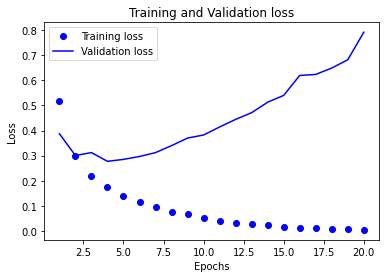

In [20]:
# 훈련과 검증 손실 그리기
history_dict = history.history
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(loss) + 1)

import matplotlib.pyplot as plt

plt.plot(epochs, loss, 'bo', label='Training loss') # 'bo'는 파란색 점을 의미
plt.plot(epochs, val_loss, 'b', label='Validation loss') # 'b'는 파란색 실선을 의미
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

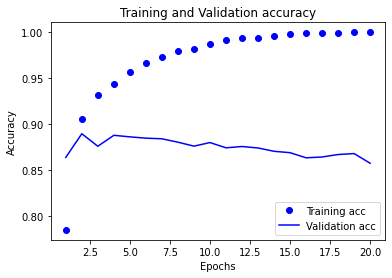

In [21]:
# 훈련과 검증 정확도 그리기

plt.clf() # 그래프를 초기화
acc = history_dict['acc']
val_acc = history_dict['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

여기에서 볼 수 있듯이 훈련 손실이 에포크마다 감소하고 훈련 정확도는 에포크마다 증가한다.<br>
경사 하강법 최적화를 사용했을 때 반복마다 최소화되는 것이 손실이므로 기대했던 대로이다.<br>
검증 손실과 정확도는 이와 같지 않다. 네 번째 에포크에서 그래프가 역전되는 것 같다. 이것이 훈련 세트에서 잘 작동하는 모델이 처음 보는 데이터에서는 잘 작동하지 않을 수 있다고 앞서 언급한 경고의 한 사례이다. 정확한 용어로 말하자면 과대적합(overfitting)되었다고 한다.<br>두 번째 에포크 이후부터 훈련 데이터에 과도하게 최적화되어 훈련 데이터에 특화된 표현을 학습하므로 훈련 세트 이외의 데이터에는 일반화되지 못한다.<br>이런 경우에 과대적합을 방지하기 위해서 세 번쨰 에포크 이후에 훈련을 중지할 수 있다. 일반적으로 4장에서 보게 될 과대적합을 완화하는 다양한 종류의 기술을 사용할 수 있다.

##### 처음부터 훈련
처음부터 다시 새로운 신경망을 네 번의 에포크 동안만 훈련하고 테스트 데이터에서 평가해본다

In [23]:
# 모델을 처음부터 다시 훈련하기

model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

model.fit(x_train, y_train, epochs=4, batch_size=512)
results = model.evaluate(x_test, y_test)

results

Epoch 1/4
49/49 [==============================] - 1s 9ms/step - loss: 0.4633 - accuracy: 0.8215
Epoch 2/4
49/49 [==============================] - 0s 9ms/step - loss: 0.2617 - accuracy: 0.9086
Epoch 3/4
49/49 [==============================] - 0s 8ms/step - loss: 0.1999 - accuracy: 0.9288
Epoch 4/4
782/782 [==============================] - 1s 1ms/step - loss: 0.2939 - accuracy: 0.8851


[0.29393669962882996, 0.8851199746131897]

##### 훈련된 모델로 새로운 데이터에 대해 예측하기
모델을 훈련시킨 후에 이를 실전 환경에서 사용하고 싶을 것이다. predict 메서드를 사용해서 어떤 리뷰가 긍정일 확률을 예측할 수 있다.

In [24]:
model.predict(x_test)

array([[0.13023835],
       [0.99978346],
       [0.7693657 ],
       ...,
       [0.09020883],
       [0.05403212],
       [0.63320684]], dtype=float32)

##### 예제에서 배운 것
- 원본 데이터를 신경망에 텐서로 주입하기 위해서는 꽤 많은 전처리가 필요
- relu 활성화 함수와 함께 Dense 층을 쌓은 네트워크는 여러 종류의 문제에 적용할 수 있어 앞으로 자주 사용하게 될 것
- (출력 클래스가 2개인)이진 분류 문제에서 네트워크는 하나의 유닛과 sigmoid 활성화 함수를 가진 Dense 층으로 끝나야 한다. 이 신경망의 출력은 확률을 나타내는 0과 1 사이의 스칼라 값이다.
- 이진 분류 문제에서 이런 스칼라 시그모이드 출력에 대해 사용할 손실 함수는 binary_crossentropy이다.
- rmsprop 옵티마이저는 문제에 상관없이 일반적으로 충분히 좋은 선택이다.
- 훈련 데이터에 대해 성능이 향상됨에 따라 신경망은 과대적합되기 시작하고 이전에 본적없는 데이터에서는 결과가 점점 나빠지게 된다. 항상 훈련 세트 이외의 데이터에서 성능을 모니터링해야 한다.

##### 대충 정리해보면...

1. 데이터가 엄청 엄청 많아야함(몇 만개)
2. 이 데이터들을 텐서(tensor)로 전처리
3. ML의 model 처럼 Sequential()을 만들어 줌
4. 이 시퀀셜에 layer 층을 쌓아줌 주로 Dense 층을 쌓나봄(층을 쌓을 때 activation function을 설정할 수 있음)
5. 레이어를 쌓고 나면 컴파일을 해줌 이때, 옵티마이저, 손실함수, 매트릭스?를 설정함
6. 컴파일이 끝나면 ML로 생각하면 훈련시킬 모델이 만들어 졌다고 보면 될 거 같음
7. 모델에 fit을 해줌 epochs와 batch_size를 설정해줌
8. 끝